# 04 - Kriging
Proposito: ejecutar OK sobre la grilla.

Inputs:
- `config/project.json`
- CSV en `cfg["data_csv_path"]`

Outputs esperados:
- `outputs/figures/kriging_estimate.png`
- `outputs/tables/kriging_var.csv`


### 1. Project setup


In [1]:
import os, sys, json, glob
import pandas as pd
from IPython.display import Image, display

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
if os.path.basename(os.getcwd()) == "notebooks":
    os.chdir(PROJECT_ROOT)
else:
    PROJECT_ROOT = os.getcwd()
    os.chdir(PROJECT_ROOT)

if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

print("PROJECT_ROOT:", PROJECT_ROOT)
print("CWD:", os.getcwd())

from src.preprocess import load_and_preprocess
from src.grid import make_grid_dataframe, grid_from_extents
from src.variography import experimental_variogram_2d, fit_variogram_model
from src.kriging import ordinary_kriging_2d
from src.eda import plot_xy_scatter


PROJECT_ROOT: c:\Users\joelm\Documents\geostats
CWD: c:\Users\joelm\Documents\geostats


### 2. Load config


In [2]:
cfg_path = "config/project.json"
print("Config:", os.path.abspath(cfg_path))
with open(cfg_path, "r", encoding="utf-8") as f:
    cfg = json.load(f)

print("Data CSV:", cfg["data_csv_path"])
mapping = {
    "x": cfg["columns"].get("x"),
    "y": cfg["columns"].get("y"),
    "z": cfg["columns"].get("z"),
    "var": cfg["columns"].get("variable_objetivo"),
}
print("Column mapping:", mapping)


Config: c:\Users\joelm\Documents\geostats\config\project.json
Data CSV: csv/Conminution.csv
Column mapping: {'x': 'X', 'y': 'Y', 'z': 'Z', 'var': 'Bwi_kWh_t'}


### 3. Load data


In [3]:
df, df_raw, mapping = load_and_preprocess(cfg)

rows_before = len(df_raw)
rows_after = len(df)
removed_pct = 0.0 if rows_before == 0 else (rows_before - rows_after) * 100.0 / rows_before

print("Shape raw:", df_raw.shape, "clean:", df.shape)
print("Dtypes:\n", df.dtypes)
print("Rows removed (%):", f"{removed_pct:.2f}")
print("X range:", (df["x"].min(), df["x"].max()))
print("Y range:", (df["y"].min(), df["y"].max()))
if "z" in df.columns and df["z"].notna().any():
    print("Z range:", (df["z"].min(), df["z"].max()))
else:
    print("Z range: n/a")


Shape raw: (600, 12) clean: (600, 12)
Dtypes:
 x             float64
y             float64
z             float64
Hole ID           str
Samples_ID        str
Lote              str
domain            str
Minz              str
EM_new            str
EM                str
var           float64
Axb_SMC       float64
dtype: object
Rows removed (%): 0.00
X range: (np.float64(2363710.832), np.float64(2365405.149))
Y range: (np.float64(6485685.572631), np.float64(6487146.812069))
Z range: (np.float64(3104.889936), np.float64(3834.876096))


### 4. Kriging


In [4]:
# Grid
grid_path = "outputs/tables/grid.csv"
if os.path.exists(grid_path):
    grid_df = pd.read_csv(grid_path)
else:
    grid_cfg = cfg.get("grid", {})
    if grid_cfg.get("auto_from_data", True):
        grid_spec = grid_from_extents(
            df,
            "x",
            "y",
            "z",
            float(grid_cfg.get("dx", 25.0)),
            float(grid_cfg.get("dy", 25.0)),
            float(grid_cfg.get("dz", 5.0)),
            pad=float(grid_cfg.get("pad", 0.0)),
        )
    else:
        grid_spec = {
            "nx": grid_cfg["nx"],
            "ny": grid_cfg["ny"],
            "nz": grid_cfg.get("nz", 1),
            "xmin": grid_cfg["xmin"],
            "ymin": grid_cfg["ymin"],
            "zmin": grid_cfg.get("zmin", 0.0),
            "dx": grid_cfg["dx"],
            "dy": grid_cfg["dy"],
            "dz": grid_cfg.get("dz", 1.0),
        }

    grid_df = make_grid_dataframe(grid_spec)

# Variogram model
model_path = "outputs/models/variogram_var.json"
if os.path.exists(model_path):
    with open(model_path, "r", encoding="utf-8") as f:
        model = json.load(f)
else:
    exp = experimental_variogram_2d(df, "x", "y", "var", cfg["variogram"])
    model = fit_variogram_model(exp, float(df["var"].var(ddof=1)), model_type="spherical")

kriged = ordinary_kriging_2d(df, "x", "y", "var", grid_df, model, cfg["kriging"])

os.makedirs("outputs/figures", exist_ok=True)
os.makedirs("outputs/tables", exist_ok=True)
plot_xy_scatter(kriged, "x", "y", "estimate", "outputs/figures/kriging_estimate.png")
kriged.to_csv("outputs/tables/kriging_var.csv", index=False)


### 5. Artifacts generated


Figures: ['c:\\Users\\joelm\\Documents\\geostats\\outputs\\figures\\kriging_estimate.png']
Tables: ['c:\\Users\\joelm\\Documents\\geostats\\outputs\\tables\\kriging_var.csv']
Models: []


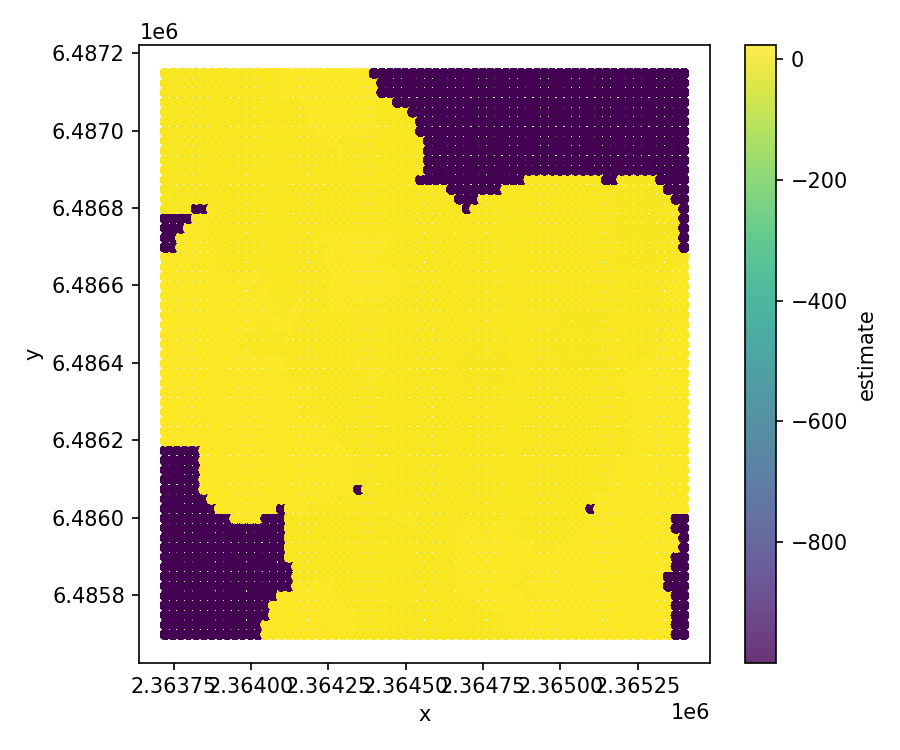

In [5]:
expected_figures = ['outputs/figures/kriging_estimate.png']
expected_tables = ['outputs/tables/kriging_var.csv']
expected_models = []

def _existing(paths):
    return [p for p in paths if os.path.exists(p)]

figure_paths = _existing(expected_figures)
table_paths = _existing(expected_tables)
model_paths = _existing(expected_models)

print("Figures:", [os.path.abspath(p) for p in figure_paths])
print("Tables:", [os.path.abspath(p) for p in table_paths])
print("Models:", [os.path.abspath(p) for p in model_paths])

for p in figure_paths:
    display(Image(filename=p))
